In [198]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(19680801)
import pandas as pd
from faker import Faker
faker = Faker()
from datetime import datetime 
from datetime import timedelta
import matplotlib.pyplot as plt
import math


In [199]:
d=datetime(2020, 4, 30)

In [414]:
def simulate_duration(datetime_created):
    #p= np.random.uniform()
    mu, sigma = 0., 1. # mean and standard deviation
    p = np.random.lognormal(mu, sigma, 1)
    duration= int(p*24*60)
    end_date= datetime_created + timedelta(minutes= duration)
    if end_date >= datetime.now():
        return -1
    return duration
def simulate_team():
    p= np.random.choice([1,2,3,4,5], 1, p=[0.5, 0.1, 0.1, 0.2,0.1])[0]
    return "Queue " + str(p)
def simulate_priority(n=1):
    prio=[]
    for p in  np.random.exponential(1,n):
        p_cap=max(1,min(5-math.ceil(p),4))
        prio.append (p_cap)
    return prio

In [415]:


row_list=[]
for n in range(0,30000):
    dict1={}
    dict1["created"]=faker.date_time_between(start_date='-120d', end_date='now')
    dict1['team']= simulate_team()
    dict1["duration"]= simulate_duration(dict1["created"])   
    dict1["priority"]= simulate_priority()[0]
    if dict1["duration"]> -1:
        dict1["closed"]= dict1["created"]+ timedelta(minutes= dict1['duration'])
        dict1['status']='Closed'
    else:
        dict1["closed"]=None
        dict1['status']='Open'
        duration_to_date=datetime.now()-dict1['created']
        dict1['duration']=duration_to_date.seconds/60
    dict1["duration_days"]= dict1["duration"]/(60*24)
    row_list.append(dict1)
df=pd.DataFrame(row_list)
#df.set_index("created_on", inplace=True)
df.insert(0, 'number', range(8000000, 8000000 + len(df)))


In [416]:
df_day_closed = df[d==df['closed'].dt.floor("d")]
df['week_commencing_date'] = pd.to_datetime(df['created']) - pd.to_timedelta(7, unit='d')
df['wc']= df['week_commencing_date'].dt.floor('d')



In [417]:
df2 = df.groupby(['status','team', pd.Grouper(key='wc', freq='W-MON')])['number'].count().reset_index().sort_values('wc')
df3= pd.pivot_table(df2, index=['wc',"team"], values=["number"], aggfunc=np.sum, columns=["status"], fill_value=0).rename(columns={'number': 'count'})
#use len for count


In [418]:
df2.team.unique()

array(['Queue 1', 'Queue 5', 'Queue 4', 'Queue 2', 'Queue 3'],
      dtype=object)

In [419]:
def get_queue_for_day(df, d, priority=0, team=""):
    if priority==0:
        df_day=df.copy()     
    else:
        df_day=df[df.priority==priority].copy()
    
    df_day_queue = df_day[ (df_day.created.dt.floor('d')<=d ) & ((df_day.closed.dt.floor('d') >= d ) | (df_day.closed.isnull()))]
    df_day_created =df_day_queue[d==df_day_queue['created'].dt.floor("d")]
    df_day_closed = df_day_queue[d==df_day_queue['closed'].dt.floor("d")]
    return [len(df_day_queue),len(df_day_created), len(df_day_closed),priority,team]

In [420]:
def simulate_period(start_date,end_date,priority=0,team=""):
    sim_period=[]
    delta = timedelta(days=1)
    d=start_date
    while d <= end_date:
        row= [d]+get_queue_for_day(df,d,priority, team)
        sim_period.append(row)
        d += delta
    return sim_period

In [421]:
df.groupby(['team'])['number'].count().reset_index().sort_values('number',ascending=False)

,team,number
0,Queue 1,14962
3,Queue 4,6013
2,Queue 3,3026
4,Queue 5,3017
1,Queue 2,2982


In [425]:
team="Queue 2"
sim_all=simulate_period(datetime(2020,3,1),datetime.now(),0,team)
sim_p1=simulate_period(datetime(2020,3,1),datetime.now(),1,team)
sim_p2=simulate_period(datetime(2020,3,1),datetime.now(),2,team)
sim_p3=simulate_period(datetime(2020,3,1),datetime.now(),3,team)
sim_p4=simulate_period(datetime(2020,3,1),datetime.now(),4, team)
dfsim_all=pd.DataFrame(sim_all,columns=['date','queue','opened','closed','priority','team']).set_index('date')
dfsim_p1= pd.DataFrame(sim_p1, columns=['date','queue','opened','closed','priority','team']).set_index('date')
dfsim_p2= pd.DataFrame(sim_p2, columns=['date','queue','opened','closed','priority','team']).set_index('date')
dfsim_p3= pd.DataFrame(sim_p3, columns=['date','queue','opened','closed','priority','team']).set_index('date')
dfsim_p4= pd.DataFrame(sim_p4, columns=['date','queue','opened','closed','priority','team']).set_index('date')

sim_conso=[]
for n in range(len(sim_all)):
    sim_conso.append(sim_all[n][:4]+sim_p1[n][1:4]+sim_p2[n][1:4]+sim_p3[n][1:4]+sim_p4[n][1:4])
dfsim_conso=pd.DataFrame(sim_conso,columns=['date','queue_all','opened_all','closed_all','queue_p1','opened_p1','closed_p1','queue_p2','opened_p2','closed_p2','queue_p3','opened_p3','closed_p3','queue_p4','opened_p4','closed_p4']).set_index('date')


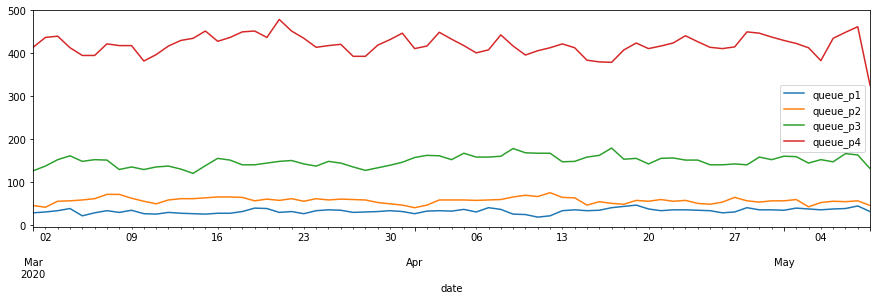

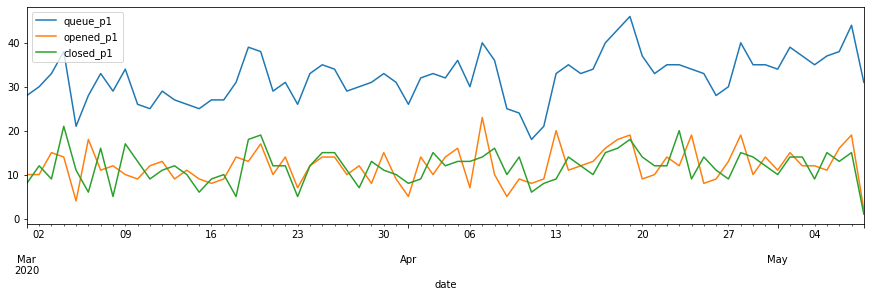

In [426]:
dfsim_conso.plot(y=["queue_p1",'queue_p2','queue_p3','queue_p4'], figsize=(15,4))
dfsim_conso.plot(y=["queue_p1",'opened_p1','closed_p1'], figsize=(15,4))

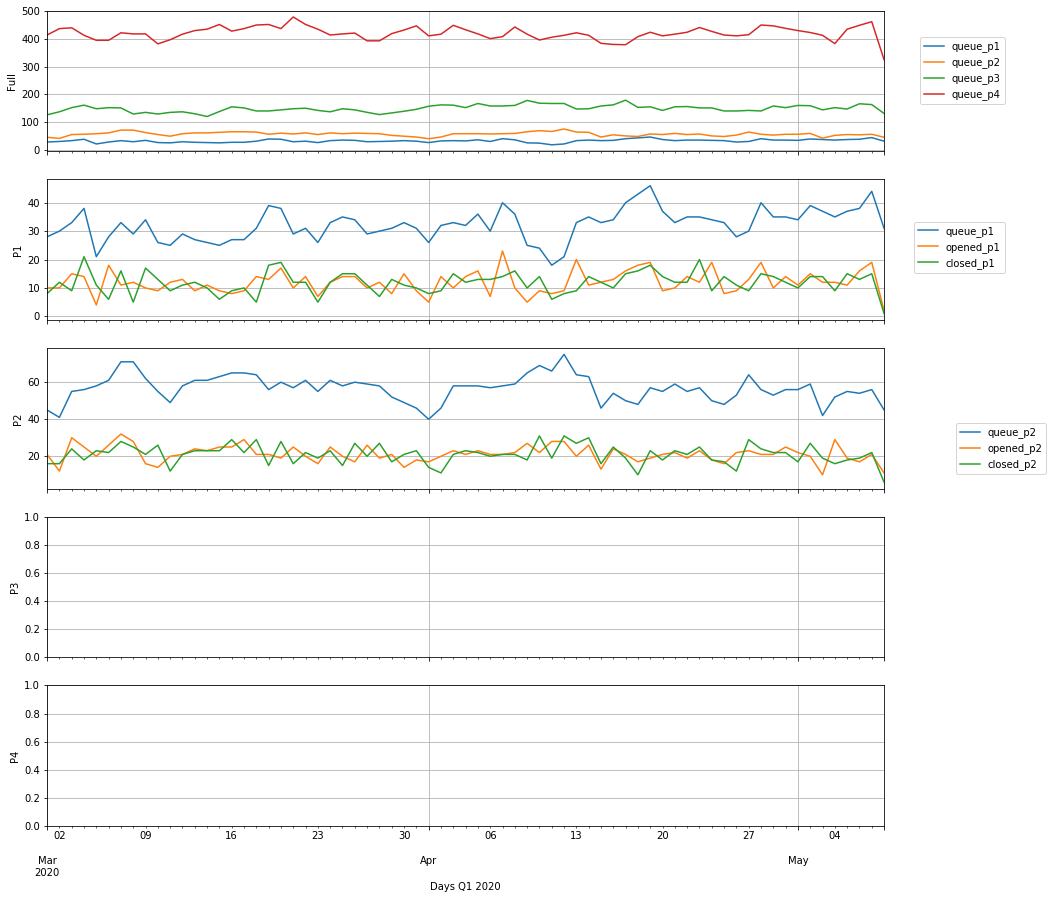

In [442]:
#https://ourcodingclub.github.io/tutorials/pandas-time-series/

fig, axes = plt.subplots(5, 1, figsize=(15,15), sharex=True)
dfsim_conso[["queue_p1",'queue_p2','queue_p3','queue_p4']].plot(ax=axes[0], label="Full Queue").legend(loc="lower right",bbox_to_anchor=(1.15,.3))
dfsim_conso.plot(y=["queue_p1",'opened_p1','closed_p1'], ax=axes[1]).legend(loc="lower right",bbox_to_anchor=(1.15,.3))
dfsim_conso.plot(y=["queue_p2",'opened_p2','closed_p2'], ax=axes[2]).legend(bbox_to_anchor=(1.2, 0.5))
axes[0].set_ylabel("Full")
axes[1].set_ylabel("P1")
axes[2].set_ylabel("P2")
axes[3].set_ylabel("P3")
axes[4].set_ylabel("P4")
axes[4].set_xlabel("Days Q1 2020")
for ax in axes:
    ax.grid()
import mdates from matplotlib
formatter=mdates.DateFormatter("%d")
axes[4].xaxis.set_minor_formatter(formatter)
fig.autofmt_xdate()